In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Load the MNIST dataset, False makes it return the data as a NumPy array
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [2]:
X, y = mnist['data'], mnist['target']

# Convert labels to integer for easier processing
y = y.astype(int)

# Initialize an empty array to hold the filtered dataset
filtered_X = np.empty((0, X.shape[1]))
filtered_y = []

# Iterate over each class and select the first 500 samples
for label in range(10):  # There are 10 classes in MNIST (0 through 9)
    # Find indices of the current class
    indices = np.where(y == label)[0][:500]  # Select first 500 indices for the class
    # Append the selected samples and their labels to the filtered datasets
    filtered_X = np.vstack((filtered_X, X[indices]))
    filtered_y.extend([label] * 500)  # Extend the labels list

# Convert the filtered labels list back to a NumPy array for consistency
filtered_y = np.array(filtered_y)

filtered_X.shape, filtered_y.shape


((5000, 784), (5000,))

# Implementation

### As instructed, I use the scikit implementation of the cosine distance

In [5]:
X_train = filtered_X
cov_matrix = np.cov(X_train, rowvar=False)
print(cov_matrix)
# modify
#cov_matrix = cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-6
cov_matrix_inv = np.linalg.pinv(cov_matrix)
cov_matrix_inv

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# "You can use the scikit implementation of the cosine distance"
from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(a, b):
    # change formate to meet par-input foramt
    similarity = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))
    return 1 - similarity

def mahalanobis_distance(x, y, VI=cov_matrix_inv):
    delta = x - y
    return np.sqrt(np.dot(np.dot(delta, VI), delta))

np.random.seed(42) # for result reproduction ONLY
# kmeans with M-Dis & cosine
# Distance metric: M and cos
def kmeans(X, k, max_iter=100, dis="M",tol=1e-4):
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]
    for ite in range(max_iter):
        # init var
        clusters = np.array([])
        if dis == "M":
            clusters = np.array([np.argmin([
                mahalanobis_distance(x, centroid, cov_matrix_inv) for centroid in centroids])
            for x in X])
        elif dis == "cos":
            clusters = np.array([np.argmin([
                cosine_distance(x, centroid) for centroid in centroids])
            for x in X])
        new_centroids = np.array([X[clusters == j].mean(axis=0) for j in range(k)])
        diff = np.sqrt(((new_centroids - centroids) ** 2).sum(axis=1))

        # 如果所有质心的移动距离都小于tol，则终止迭代
        if np.all(diff < tol):
            print(f"Terminating at iteration {ite}: centroid shift {diff.max()} within tolerance {tol}.")
            break
        centroids = new_centroids
    return clusters, centroids

# clusters, centroids = kmeans(X_train, 5, dis="M")
# print(clusters,"/n")
# print(centroids)

In [7]:
def calculate_cluster_consistency(labels_true, labels_pred, k):
    cluster_consistency = np.zeros(k)

    for i in range(k):
        # 找出属于当前簇的所有数据点的真实标签
        cluster_labels = labels_true[labels_pred == i]

        # 如果当前簇为空，则跳过
        if len(cluster_labels) == 0:
            continue

        # 计算每个标签的数据点数量并找出数量最多的标签
        _, counts = np.unique(cluster_labels, return_counts=True)
        m_i = np.max(counts)  # 最多标签的数据点数量
        N_i = len(cluster_labels)  # 簇内总数据点数

        # 计算簇的一致性
        cluster_consistency[i] = m_i / N_i

    # 计算整体聚类一致性Q
    Q = np.mean(cluster_consistency[cluster_consistency > 0])  # 排除空簇的影响
    return Q

# 假设 labels_true 和 labels_pred 已经定义
# Q = calculate_cluster_consistency(y_train, clusters, 5)
# print(f"整体聚类一致性Q: {Q}")


# 2.k_list = [5,10,20,40,200]

# 3.calc Q

Terminating at iteration 29: centroid shift 0.0 within tolerance 0.0001.
cos 5 0.4967215207888006
Terminating at iteration 56: centroid shift 0.0 within tolerance 0.0001.
cos 10 0.5995416972251939
Terminating at iteration 27: centroid shift 0.0 within tolerance 0.0001.
cos 20 0.7592568200823244
Terminating at iteration 38: centroid shift 0.0 within tolerance 0.0001.
cos 40 0.793561511625709
Terminating at iteration 19: centroid shift 0.0 within tolerance 0.0001.
cos 200 0.8816353107032902


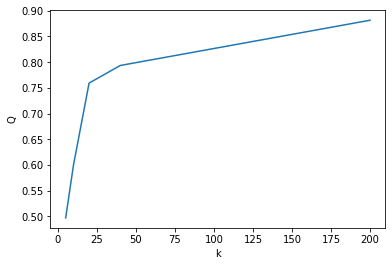

In [8]:
k_list = [5,10,20,40,200]
y_train = filtered_y
#k_list = [40,200]
def kmeans_plot(X, max_iter=100, dis="cos"):
    distances = [] # Q list
    for k in k_list:
        clusters, centroids = kmeans(X_train, k, dis=dis)
        Q = calculate_cluster_consistency(y_train, clusters, k)
        distances.append(Q)
        print(dis, k, Q)
    plt.plot(k_list, distances)
    plt.xlabel("k")
    plt.ylabel("Q")
    plt.show()
    #return distances

# cos
kmeans_plot(X_train,dis="cos")

Terminating at iteration 33: centroid shift 0.0 within tolerance 0.0001.
M 5 0.3616454201925333
Terminating at iteration 26: centroid shift 0.0 within tolerance 0.0001.
M 10 0.555626063805575
Terminating at iteration 35: centroid shift 0.0 within tolerance 0.0001.
M 20 0.6329275713741819
Terminating at iteration 58: centroid shift 0.0 within tolerance 0.0001.
M 40 0.776522969576391
Terminating at iteration 60: centroid shift 0.0 within tolerance 0.0001.
M 200 0.8428442169539155


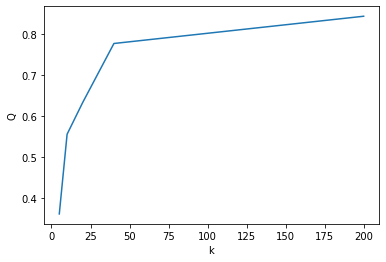

In [9]:
kmeans_plot(X_train, dis="M")

#### store results of 2 and get Q

In [10]:
def calculate_cluster_consistency(labels_true, labels_pred, k):
    cluster_consistency = np.zeros(k)

    for i in range(k):
        # 找出属于当前簇的所有数据点的真实标签
        cluster_labels = labels_true[labels_pred == i]

        # 如果当前簇为空，则跳过
        if len(cluster_labels) == 0:
            continue

        # 计算每个标签的数据点数量并找出数量最多的标签
        _, counts = np.unique(cluster_labels, return_counts=True)
        m_i = np.max(counts)  # 最多标签的数据点数量
        N_i = len(cluster_labels)  # 簇内总数据点数

        # 计算簇的一致性
        cluster_consistency[i] = m_i / N_i

    # 计算整体聚类一致性Q
    Q = np.mean(cluster_consistency[cluster_consistency > 0])  # 排除空簇的影响
    return Q

# 假设 labels_true 和 labels_pred 已经定义
# Q = calculate_cluster_consistency(y_train, M_clusters, 10)
# print(f"整体聚类一致性Q: {Q}")
